In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from pprint import pprint
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31089 entries, 0 to 31088
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             31089 non-null  float64
 1   bath            31089 non-null  float64
 2   acre_lot        31089 non-null  float64
 3   zip_code        31089 non-null  float64
 4   house_size      31089 non-null  float64
 5   price           31089 non-null  float64
 6   prev_sold_year  20505 non-null  float64
 7   latitude        31089 non-null  float64
 8   longitude       31089 non-null  float64
 9   county          31089 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 2.4 MB


In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8401.0

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [6]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 27442 to 27813
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             372 non-null    float64
 1   bath            372 non-null    float64
 2   acre_lot        372 non-null    float64
 3   zip_code        372 non-null    float64
 4   house_size      372 non-null    float64
 5   price           372 non-null    float64
 6   prev_sold_year  243 non-null    float64
 7   latitude        372 non-null    float64
 8   longitude       372 non-null    float64
 9   county          372 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 32.0 KB


In [7]:
# "data":one_zipcode_df,

params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude","county"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
#normalize_df = mean_and_std(params)
normalize_df = outliers_df
normalize_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,latitude,longitude,county
31084,3.0,2.0,0.93,8886.0,1500.0,170000.0,NaN,40.687502,-75.101127,19
31085,3.0,2.0,0.23,8886.0,1500.0,69800.0,2021.0,40.687502,-75.101127,19
31086,3.0,2.0,0.92,8886.0,1500.0,170000.0,NaN,40.687502,-75.101127,19
31087,4.0,3.0,0.31,8886.0,1500.0,459000.0,2009.0,40.687502,-75.101127,19
31088,3.0,2.0,0.14,8886.0,1500.0,79900.0,2020.0,40.687502,-75.101127,19


In [8]:
correlation = normalize_df[["latitude","longitude","acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

latitude          0.097584
longitude         0.263718
acre_lot          0.015676
bed               0.416213
bath              0.587738
house_size        0.335343
prev_sold_year    0.031541
price             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

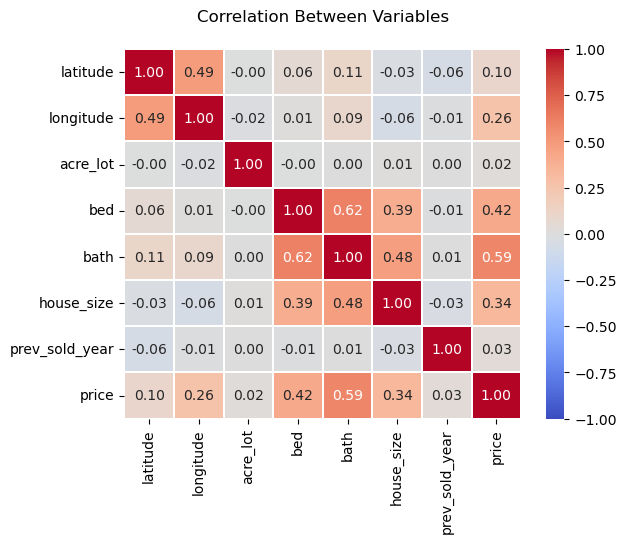

In [9]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [10]:
corrfeatures = ["latitude","longitude"]
#corrfeatures = []
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.17:
        corrfeatures.append(feature)
        
savefeatures = list(dict.fromkeys(corrfeatures))
print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [11]:
pariplot_features = []
for feature, value in correlation["price"].items():
        pariplot_features.append(feature)

In [12]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

In [13]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [14]:
dtree_params = {'max_depth': range(1,6,1),
         'random_state':[42]}

dtree_grid_searchc = GridSearchCV(DecisionTreeRegressor(), param_grid=dtree_params).fit(X, y)

dtree_best_params = dtree_grid_searchc.best_params_

In [15]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

poly_degrees = range(1,5,1)

poly_pipeline_params={"poly_features__degree":poly_degrees,"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=poly_pipeline_params, cv=5, verbose=1)
poly_grid_searchcv.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('poly_model', LinearRegression())]),
             param_grid={'poly_features__degree': range(1, 5),
                         'poly_features__include_bias': [False],
                         'poly_model__fit_intercept': [True]},
             verbose=1)

In [16]:
poly_best_params = {}
for what in poly_grid_searchcv.best_params_:
    if poly_best_params.get(what) == None:
        poly_best_params[what] = []
    poly_best_params[what].append(poly_grid_searchcv.best_params_[what])

In [17]:
#best_params = poly_best_params
best_params = dtree_best_params
best_params

{'max_depth': 4, 'random_state': 42}

In [18]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [19]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

In [20]:
'''
config = {
    "kind" : "Polynomial",
    "title" : "Polynomial",
    "df" : normalize_df,
    "features" : features,
    "target" : "price",
    "best_params" : best_params
}
config = {
    "kind" : "Decision Tree",
    "title" : "Decision Tree Best Params",
    "df" : normalize_df,
    "features" : features,
    "target" : "price",
    "best_params" : best_params
}
'''

'\nconfig = {\n    "kind" : "Polynomial",\n    "title" : "Polynomial",\n    "df" : normalize_df,\n    "features" : features,\n    "target" : "price",\n    "best_params" : best_params\n}\nconfig = {\n    "kind" : "Decision Tree",\n    "title" : "Decision Tree Best Params",\n    "df" : normalize_df,\n    "features" : features,\n    "target" : "price",\n    "best_params" : best_params\n}\n'

In [21]:
config = {
    "kind" : "Linear",
    "title" : "Linear",
    "df" : normalize_df,
    "features" : features,
    "target" : "price",
    "best_params" : {}
}

In [22]:
dtree = dosomething(config)
results_dict_append(dtree["results"])
dtree_bp_predict = dtree["predictions"]

Linear EVS = 0.414389001
Linear MSE = 114,068,053,173.643997
Linear MAE = 217,202.438845
Linear R2 = 0.414364
Linear Fit Time = 0.005490016937255859


In [23]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

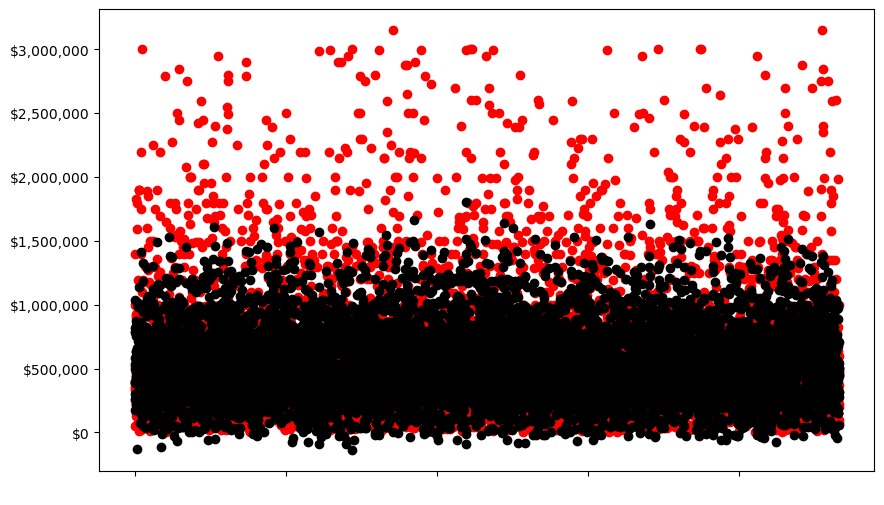

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

In [25]:
results_dict

{'model': ['Linear'],
 'explained variance score': ['0.414389001'],
 'mae score': ['217,202.438845'],
 'mse score': ['114,068,053,173.643997'],
 'r2 score': ['0.414364'],
 'mean fit time': [0.005490016937255859]}

In [26]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Linear,0.414389001,"217,202.438845","114,068,053,173.643997",0.414364,0.00549


In [27]:
not_normlized_features = {'model': ['Polynomial'],
 'explained variance score': ['0.461866633'],
 'mae score': ['202,705.578774'],
 'mse score': ['104,818,481,010.300293'],
 'r2 score': ['0.461852'],
 'mean fit time': [0.014710187911987305]}

normlized_features = {'model': ['Polynomial'],
 'explained variance score': ['0.461866632'],
 'mae score': ['0.461743'],
 'mse score': ['0.543884'],
 'r2 score': ['0.461852'],
 'mean fit time': [0.015564250946044921]}